In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("raakaliikennemaara_h_2024-03-05-2024-05-23.csv",delimiter=";")
df['pvm'] = pd.to_datetime(df['pvm'], format='%Y%m%d')

In [3]:
columns_to_replace = df.columns[6:-1] 

df[columns_to_replace] = df[columns_to_replace].fillna(df[columns_to_replace].median())
df['yhteensa'] = df.iloc[:, 6:-1].sum(axis=1)

In [4]:
melted_df = df.melt(id_vars=['pistetunnus', 'sijainti', 'pvm', 'suunta', 'suuntaselite', 'kaista', 'yhteensa'], var_name='Hour', value_name='Traffic')

melted_df[['Start_Hour', 'End_Hour']] = melted_df['Hour'].str.split('_', expand=True)


melted_df.drop(columns=['Hour'], inplace=True)


melted_df = melted_df[['pistetunnus', 'sijainti', 'pvm', 'suunta', 'suuntaselite', 'kaista', 'Start_Hour', 'End_Hour', 'Traffic', 'yhteensa']]
melted_df['pvm'] = melted_df['pvm'].astype(str) + ' ' + melted_df['Start_Hour'] + ':00'

melted_df['pvm'] = pd.to_datetime(melted_df['pvm'])

melted_df = melted_df.drop(columns=["yhteensa"])
melted_df = melted_df.sort_values(by="pvm")
melted_df.head(5)

,pistetunnus,sijainti,pvm,suunta,suuntaselite,kaista,Start_Hour,End_Hour,Traffic
0,923,vt4_Jyväskylä_Halssila,2024-03-05 00:00:00,*,NaN,*,00,01,109.0
79,923,vt4_Jyväskylä_Halssila,2024-03-05 01:00:00,*,NaN,*,01,02,95.0
158,923,vt4_Jyväskylä_Halssila,2024-03-05 02:00:00,*,NaN,*,02,03,87.0
237,923,vt4_Jyväskylä_Halssila,2024-03-05 03:00:00,*,NaN,*,03,04,70.0
316,923,vt4_Jyväskylä_Halssila,2024-03-05 04:00:00,*,NaN,*,04,05,177.0


In [5]:
aq = pd.read_csv("Jyväskylä Jyskä 5.3.2024 - 23.5.2024_dc4053d6-3b57-491a-a708-90f6e5f5341b.csv")

In [6]:
aq["Date"] = aq["Vuosi"].astype(str) + "-" + aq["Kuukausi"].astype(str) + "-" +  aq["Päivä"].astype(str) + " " + aq["Aika [UTC]"]
aq["Date"] = pd.to_datetime(aq["Date"])
aq.head(5)

,Havaintoasema,Vuosi,Kuukausi,Päivä,Aika [UTC],Hengitettävät hiukkaset <10 µm [µg/m3],Pienhiukkaset <2.5 µm [µg/m3],Date
0,Jyväskylä Jyskä,2024,3,5,00:00,2.8,2.4,2024-03-05 00:00:00
1,Jyväskylä Jyskä,2024,3,5,01:00,2.6,2.3,2024-03-05 01:00:00
2,Jyväskylä Jyskä,2024,3,5,02:00,2.7,2.4,2024-03-05 02:00:00
3,Jyväskylä Jyskä,2024,3,5,03:00,3.1,2.6,2024-03-05 03:00:00
4,Jyväskylä Jyskä,2024,3,5,04:00,4.4,2.9,2024-03-05 04:00:00


In [7]:
import numpy as np
aq["Hengitettävät hiukkaset <10 µm [µg/m3]"] = aq["Hengitettävät hiukkaset <10 µm [µg/m3]"].replace("-", np.nan)
aq["Hengitettävät hiukkaset <10 µm [µg/m3]"] = aq["Hengitettävät hiukkaset <10 µm [µg/m3]"].astype(float)
median = aq['Hengitettävät hiukkaset <10 µm [µg/m3]'].median()
aq["Hengitettävät hiukkaset <10 µm [µg/m3]"] = aq['Hengitettävät hiukkaset <10 µm [µg/m3]'].fillna(median, inplace=False)

aq["Hengitettävät hiukkaset <10 µm [µg/m3]"].corr(melted_df["Traffic"])

-0.011434951809841687

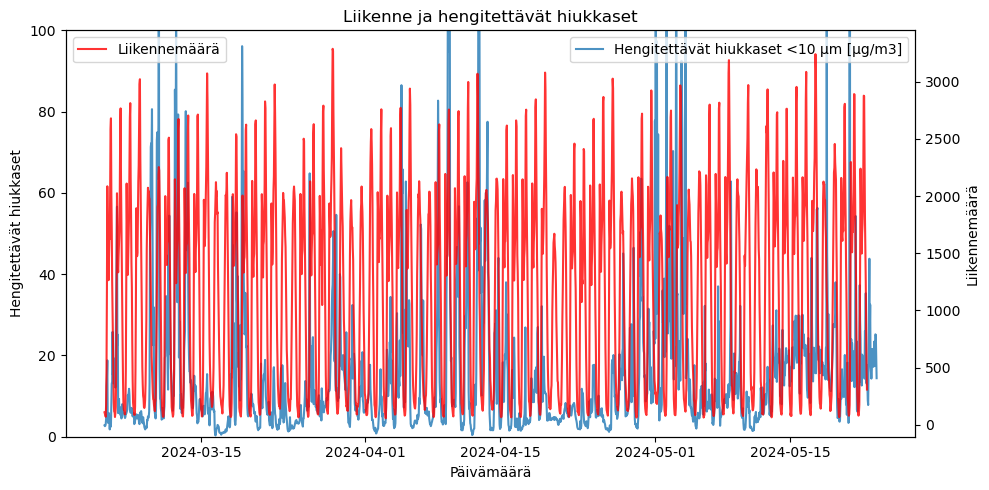

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns



fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(aq['Date'], aq['Hengitettävät hiukkaset <10 µm [µg/m3]'], label='Hengitettävät hiukkaset <10 µm [µg/m3]', alpha=0.8)
ax2.plot(melted_df['pvm'], melted_df['Traffic'], label='Liikennemäärä', color="red", alpha=0.8)

ax1.set_xlabel('Päivämäärä')
ax1.set_ylabel('Hengitettävät hiukkaset')


ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Liikennemäärä')

ax1.legend(loc="upper right")
ax2.legend()

ax1.set_ylim(0,100)

plt.title('Liikenne ja hengitettävät hiukkaset')
plt.tight_layout()

plt.show()

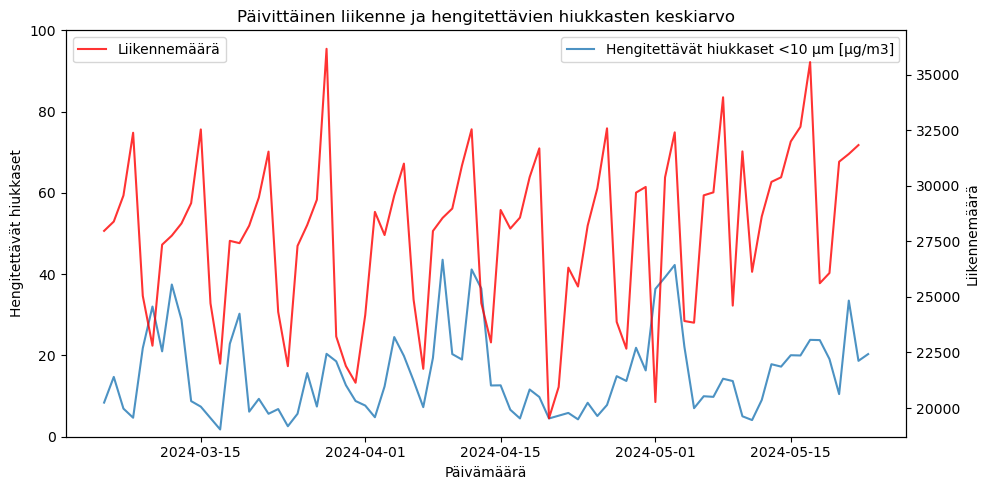

In [9]:
copy = aq.set_index('Date', inplace=False)
columns_to_average = ["Hengitettävät hiukkaset <10 µm [µg/m3]"]
daily_df = copy[columns_to_average].resample('D').mean()
daily_df.reset_index(inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(daily_df['Date'], daily_df['Hengitettävät hiukkaset <10 µm [µg/m3]'], label='Hengitettävät hiukkaset <10 µm [µg/m3]', alpha=0.8)
ax2.plot(df['pvm'], df['yhteensa'], label='Liikennemäärä', color="red", alpha=0.8)

ax1.set_xlabel('Päivämäärä')
ax1.set_ylabel('Hengitettävät hiukkaset')


ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Liikennemäärä')

ax1.legend(loc="upper right")
ax2.legend()

ax1.set_ylim(0,100)

plt.title('Päivittäinen liikenne ja hengitettävien hiukkasten keskiarvo')
plt.tight_layout()

plt.show()

In [10]:
print(f"Päivittäinen korrelaatio: {daily_df['Hengitettävät hiukkaset <10 µm [µg/m3]'].corr(df['yhteensa'])}")


print(f"Tuntikorrelaatio: {aq['Hengitettävät hiukkaset <10 µm [µg/m3]'].corr(melted_df['Traffic'])}")


Päivittäinen korrelaatio: 0.16462384891894974
Tuntikorrelaatio: -0.011434951809841687


In [11]:
# Viikonpäivän mukaan


melted_df = melted_df.rename(columns={"pvm": "Date"})

df_merged = pd.merge(aq, melted_df, on='Date')


df_merged['weekday'] = df_merged['Date'].dt.day_name()


# df_merged

df_avg = df_merged.groupby('weekday').agg({
    'Hengitettävät hiukkaset <10 µm [µg/m3]': 'mean',
    'Traffic': 'sum'
}).reset_index()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_avg['weekday'] = pd.Categorical(df_avg['weekday'], categories=weekday_order, ordered=True)
df_avg = df_avg.sort_values('weekday')
df_avg

,weekday,Hengitettävät hiukkaset <10 µm [µg/m3],Traffic
1,Monday,14.114394,310045.0
5,Tuesday,18.992708,343746.0
6,Wednesday,16.002778,345864.0
4,Thursday,16.232576,332775.0
0,Friday,16.910985,346976.0
2,Saturday,15.049621,264635.0
3,Sunday,10.831818,254680.0


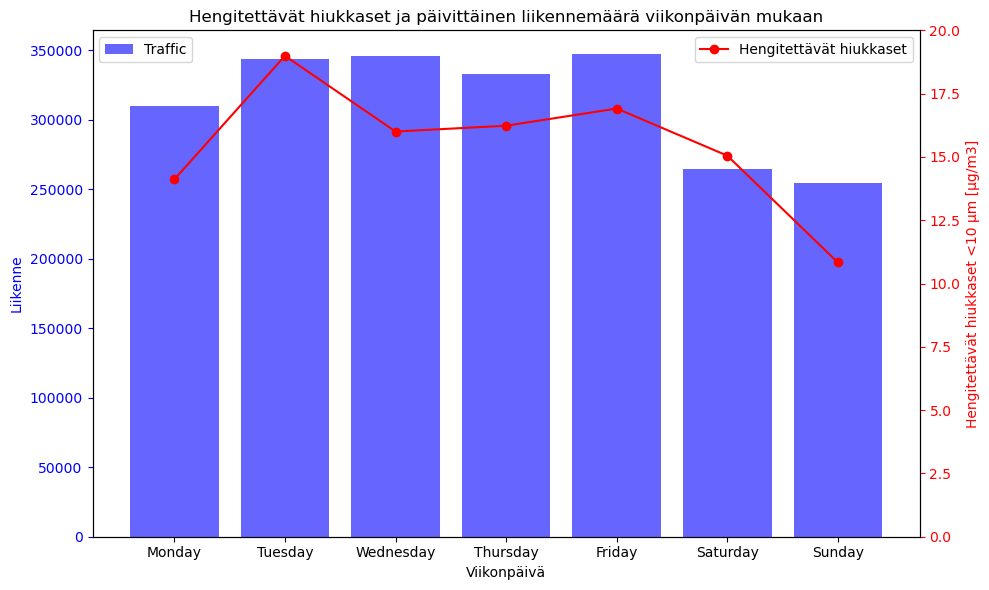

In [12]:
df = df_avg


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.bar(df['weekday'], df['Traffic'], color='b', alpha=0.6, label='Traffic')


ax2 = ax1.twinx()
ax2.plot(df['weekday'], df['Hengitettävät hiukkaset <10 µm [µg/m3]'], color='r', marker='o', label='Hengitettävät hiukkaset')


ax1.set_xlabel('Viikonpäivä')
ax1.set_ylabel('Liikenne', color='b')
ax2.set_ylabel('Hengitettävät hiukkaset <10 µm [µg/m3]', color='r')
ax1.set_title('Hengitettävät hiukkaset ja päivittäinen liikennemäärä viikonpäivän mukaan')


ax1.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')

ax2.set_ylim(0,20)

plt.xticks(rotation=45)


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()